# Chapter 5 - The Mechanics of Learning

## Part I: Parameter Estimation

In [1]:
import numpy as np
import torch
torch.set_printoptions(edgeitems=2, linewidth=75)
%matplotlib inline

In [2]:
t_c = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]

In [3]:
t_c = torch.Tensor(t_c)
t_u = torch.Tensor(t_u)

### Visualizing the Data

In [4]:
import matplotlib.pyplot as plt

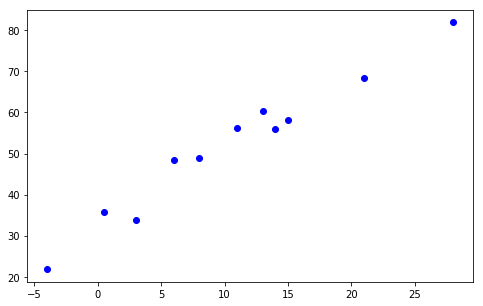

In [10]:
plt.figure(figsize=(8, 5))
plt.plot(t_c, t_u, 'bo')
plt.show()

### Choosing a linear model as a first try

In [11]:
def model(t_u, w, b):
    return w * t_u + b

In [12]:
def loss_fn(t_p, t_c):
    squared_diffs = (t_p - t_c)**2
    return squared_diffs.mean()

In [13]:
w = torch.ones(())
w.shape

torch.Size([])

In [14]:
b = torch.zeros(())
b.shape

torch.Size([])

In [15]:
t_p = model(t_u, w, b)
t_p

tensor([35.7000, 55.9000, 58.2000, 81.9000, 56.3000, 48.9000, 33.9000,
        21.8000, 48.4000, 60.4000, 68.4000])

In [17]:
w, b

(tensor(1.), tensor(0.))

In [18]:
loss = loss_fn(t_p, t_c)
loss

tensor(1763.8846)

### Broadcasting

In [19]:
x = torch.ones(())
y = torch.ones(3, 1)
z = torch.ones(1, 3)
a = torch.ones(2, 1, 1)

print(f"shapes: x: {x.shape}, y: {y.shape}")
print(f"        z: {z.shape}, a: {a.shape}")
print('\n')
print("x * y:", (x * y).shape)
print("y * z:", (y * z).shape)
print("y * z * a:", (y * z * a).shape)

shapes: x: torch.Size([]), y: torch.Size([3, 1])
        z: torch.Size([1, 3]), a: torch.Size([2, 1, 1])


x * y: torch.Size([3, 1])
y * z: torch.Size([3, 3])
y * z * a: torch.Size([2, 3, 3])


### Down along the gradient

In [20]:
delta = 0.1

loss_rate_of_change_w = \
    (loss_fn(model(t_u, w + delta, b), t_c) - 
     loss_fn(model(t_u, w - delta, b), t_c)) / (2.0 * delta)

In [21]:
loss_rate_of_change_w

tensor(4517.2979)

In [22]:
lr = 1e-2

w = w - lr * loss_rate_of_change_w
w

tensor(-44.1730)

In [23]:
loss_rate_of_change_b = \
    (loss_fn(model(t_u, w, b + delta), t_c) - 
     loss_fn(model(t_u, w, b - delta), t_c)) / (2.0 * delta)

b = b - lr * loss_rate_of_change_b
b

tensor(46.0250)

### Getting analytical

In [24]:
def dloss_fn(t_p, t_c):
    dsq_diffs = 2 * (t_p - t_c) / t_p.size(0)
    return dsq_diffs

In [25]:
def dmodel_dw(t_u, w, b):
    return t_u

In [26]:
def dmodel_db(t_u, w, b):
    return 1.0

In [27]:
def grad_fn(t_u, t_c, t_p, w, b):
    dloss_dtp = dloss_fn(t_p, t_c)
    dloss_dw = dloss_dtp * dmodel_dw(t_u, w, b)
    dloss_db = dloss_dtp * dmodel_db(t_u, w, b)
    return torch.stack([dloss_dw.sum(), dloss_db.sum()])

### Iterating to fit the model

In [28]:
def training_loop(n_epochs, lr, params, t_u, t_c, print_params=True):
    for epoch in range(1, n_epochs + 1):
        w, b = params
        t_p = model(t_u, w, b)
        loss = loss_fn(t_p, t_c)
        grad = grad_fn(t_u, t_c, t_p, w, b)
        
        params = params - lr * grad
        
        if epoch in {1, 2, 3, 10, 11, 99, 100, 4000, 5000}:
            print('Epoch {}, Loss {}'.format(epoch, float(loss)))
            if print_params:
                print('    Params:', params)
                print('    Grad:', grad)
        if epoch in {4, 12, 101}:
            print('...')
        if not torch.isfinite(loss).all():
            break
            
    return params

In [29]:
training_loop(
    n_epochs=100,
    lr=1e-2,
    params=torch.Tensor([1.0, 0.0]),
    t_u=t_u,
    t_c=t_c)

Epoch 1, Loss 1763.8846435546875
    Params: tensor([-44.1730,  -0.8260])
    Grad: tensor([4517.2969,   82.6000])
Epoch 2, Loss 5802485.5
    Params: tensor([2568.4014,   45.1637])
    Grad: tensor([-261257.4219,   -4598.9712])
Epoch 3, Loss 19408035840.0
    Params: tensor([-148527.7344,   -2616.3933])
    Grad: tensor([15109614.0000,   266155.7188])
...
Epoch 10, Loss 9.090115470662065e+34
    Params: tensor([3.2144e+17, 5.6621e+15])
    Grad: tensor([-3.2700e+19, -5.7600e+17])
Epoch 11, Loss inf
    Params: tensor([-1.8590e+19, -3.2746e+17])
    Grad: tensor([1.8912e+21, 3.3313e+19])


tensor([-1.8590e+19, -3.2746e+17])

In [30]:
training_loop(
    n_epochs=100,
    lr=1e-4,
    params=torch.Tensor([1.0, 0.0]),
    t_u=t_u,
    t_c=t_c)

Epoch 1, Loss 1763.8846435546875
    Params: tensor([ 0.5483, -0.0083])
    Grad: tensor([4517.2969,   82.6000])
Epoch 2, Loss 323.0905456542969
    Params: tensor([ 0.3623, -0.0118])
    Grad: tensor([1859.5493,   35.7843])
Epoch 3, Loss 78.92963409423828
    Params: tensor([ 0.2858, -0.0135])
    Grad: tensor([765.4667,  16.5122])
...
Epoch 10, Loss 29.105241775512695
    Params: tensor([ 0.2324, -0.0166])
    Grad: tensor([1.4803, 3.0544])
Epoch 11, Loss 29.104167938232422
    Params: tensor([ 0.2323, -0.0169])
    Grad: tensor([0.5781, 3.0384])
...
Epoch 99, Loss 29.023582458496094
    Params: tensor([ 0.2327, -0.0435])
    Grad: tensor([-0.0533,  3.0226])
Epoch 100, Loss 29.022668838500977
    Params: tensor([ 0.2327, -0.0438])
    Grad: tensor([-0.0532,  3.0226])


tensor([ 0.2327, -0.0438])

In [36]:
params = training_loop(
    n_epochs = 5000, 
    lr = 1e-3, 
    params = torch.tensor([1.0, 0.0]), 
    t_u = t_u, 
    t_c = t_c,
    print_params = False)

params

Epoch 1, Loss 1763.8846435546875
Epoch 2, Loss 41399.609375
Epoch 3, Loss 986624.75
...
Epoch 10, Loss 4327910768902144.0
Epoch 11, Loss 1.0321114790939853e+17
...


tensor([6.1956e+17, 1.0913e+16])

### Normalizing inputs

In [37]:
t_un = 0.1 * t_u

In [39]:
training_loop(
    n_epochs = 100, 
    lr = 1e-2, 
    params = torch.tensor([1.0, 0.0]), 
    t_u = t_un, # <1>
    t_c = t_c)

Epoch 1, Loss 80.36434173583984
    Params: tensor([1.7761, 0.1064])
    Grad: tensor([-77.6140, -10.6400])
Epoch 2, Loss 37.57491683959961
    Params: tensor([2.0848, 0.1303])
    Grad: tensor([-30.8623,  -2.3864])
Epoch 3, Loss 30.871076583862305
    Params: tensor([2.2094, 0.1217])
    Grad: tensor([-12.4631,   0.8587])
...
Epoch 10, Loss 29.030487060546875
    Params: tensor([ 2.3232, -0.0710])
    Grad: tensor([-0.5355,  2.9295])
Epoch 11, Loss 28.941875457763672
    Params: tensor([ 2.3284, -0.1003])
    Grad: tensor([-0.5240,  2.9264])
...
Epoch 99, Loss 22.21418571472168
    Params: tensor([ 2.7508, -2.4910])
    Grad: tensor([-0.4453,  2.5208])
Epoch 100, Loss 22.148710250854492
    Params: tensor([ 2.7553, -2.5162])
    Grad: tensor([-0.4446,  2.5165])


tensor([ 2.7553, -2.5162])

In [40]:
params = training_loop(
    n_epochs = 5000, 
    lr = 1e-2, 
    params = torch.tensor([1.0, 0.0]), 
    t_u = t_un, 
    t_c = t_c,
    print_params = False)

params

Epoch 1, Loss 80.36434173583984
Epoch 2, Loss 37.57491683959961
Epoch 3, Loss 30.871076583862305
...
Epoch 10, Loss 29.030487060546875
Epoch 11, Loss 28.941875457763672
...
Epoch 99, Loss 22.21418571472168
Epoch 100, Loss 22.148710250854492
...
Epoch 4000, Loss 2.927680253982544
Epoch 5000, Loss 2.927647590637207


tensor([  5.3671, -17.3012])

### Visualizing (again)

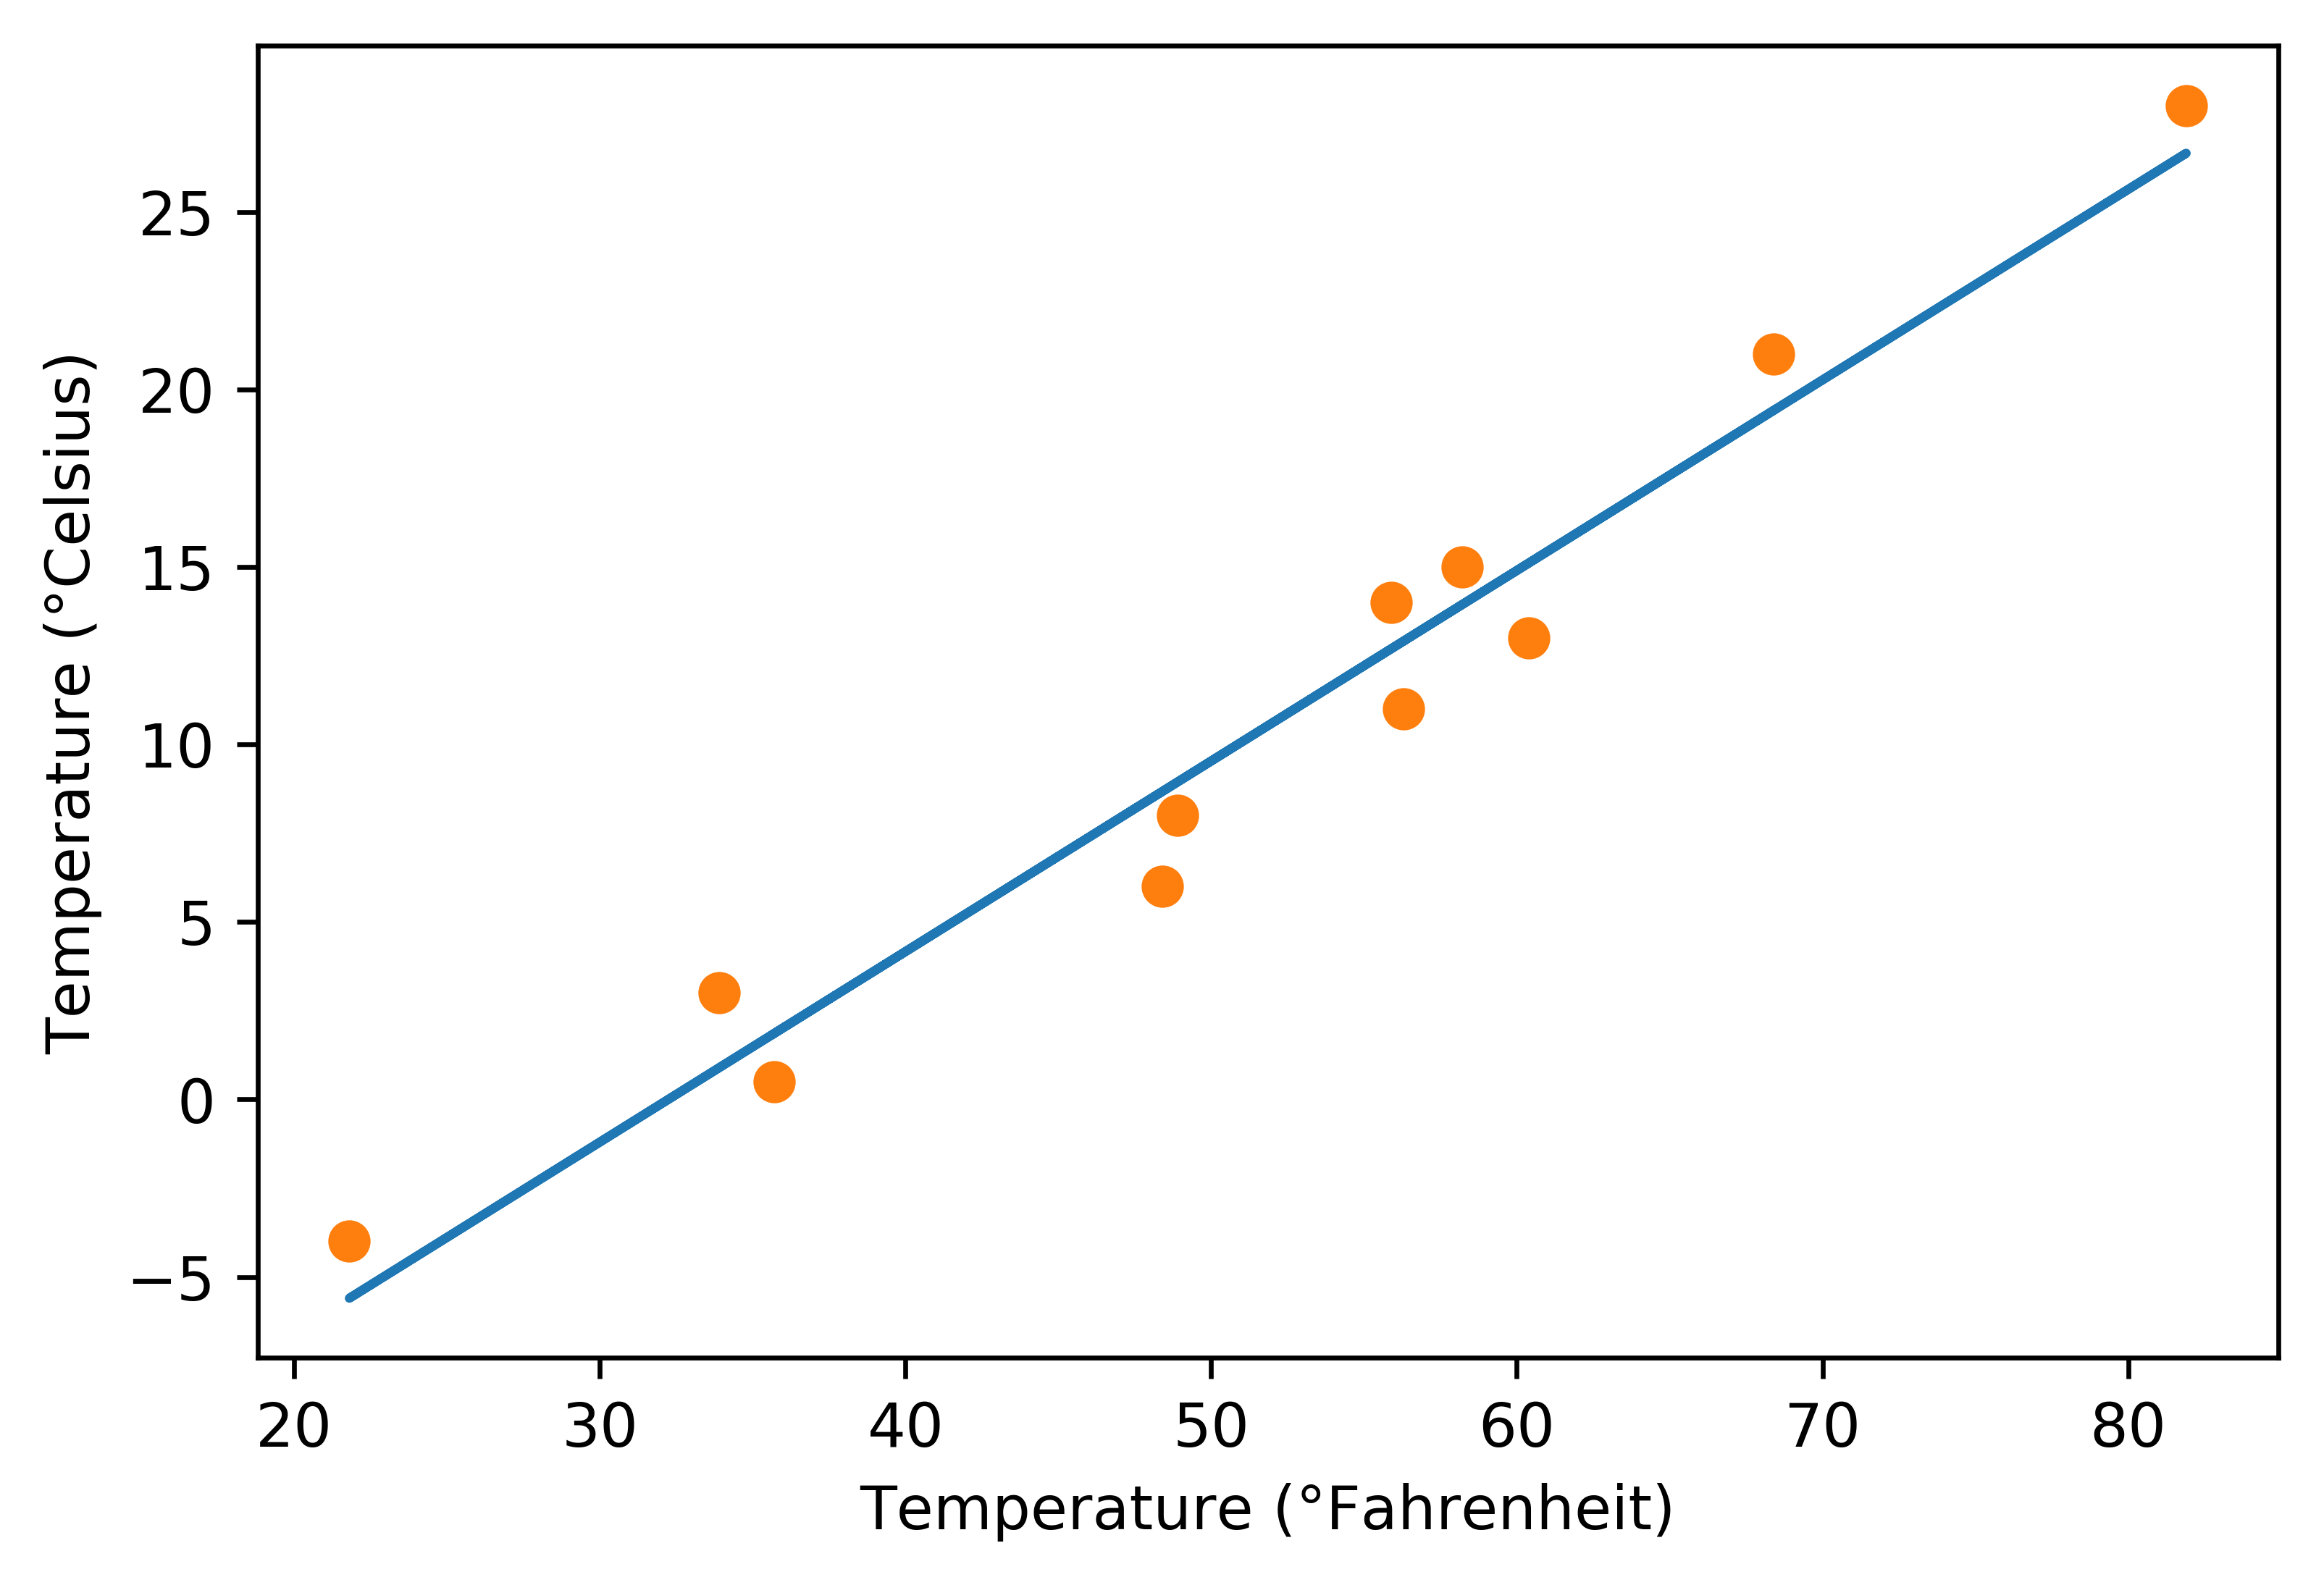

In [41]:
t_p = model(t_un, *params)

fig = plt.figure(dpi=600)
plt.xlabel("Temperature (°Fahrenheit)")
plt.ylabel("Temperature (°Celsius)")
plt.plot(t_u.numpy(), t_p.detach().numpy())
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.show()